## Modeling and Simulation in Python

Project 3

Jinfay Yuan and Manu Patil

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math
import matplotlib.pyplot as plt
import numpy as np  
from matplotlib import animation, rc
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/jyuan/Desktop/Olin 2018-2019/ModSimPy/code/modsim-Project3/FFmpeg/bin/ffmpeg'

In [2]:
N = UNITS.newton
kg = UNITS.kilogram
AU = UNITS.astronomical_unit
day = UNITS.day
m = UNITS.meter
s = UNITS.second
y = UNITS.year
degree = UNITS.degree

<Unit('degree')>

In [3]:
Mass_Earth = 5.972e24 *kg
Mass_Moon = 7.3476730e22 *kg
Mass_Satellite = 100 *kg
G = 6.674e-11* (N*m**2)/(kg**2)
r_0 = 344970933  #distance from center of Earth to Lagrange point

344970933

In [4]:
def make_system(mEarth, mMoon, mSatellite, G, r_0, v,theta, t_end):

    rad = (theta/180) * pi
    
    init = State(x = 344970933 *m, 
                 y = 0*m ,
                 vx = v* math.cos(rad) *m/s ,
                 vy = v* math.sin(rad) *m/s ,
                 mx = 384472281 *m, #distance from Earth to Moon
                 my = 0*m,
                 mvx = 0 *m/s,
                 mvy = 1000 * m/s);

    
    t_0 = 0 *s
    t_end = t_end *s
    
    
    return System(init=init,
                mEarth = mEarth,
                mMoon = mMoon,
                mSatellite = mSatellite,
                G = G,
                t_0 = t_0,
                t_end=t_end)
system = make_system(Mass_Earth, Mass_Moon, Mass_Satellite, G, r_0, 100, 100, 1000)

,values
init,x 344970933 meter y ...
mEarth,5.972e+24 kilogram
mMoon,7.347673e+22 kilogram
mSatellite,100 kilogram
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
t_0,0 second
t_end,1000 second


In [5]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy, mx, my, mvx, mvy = state
    unpack(system) 
    
    forceEarth = Earth_fgrav(state,system)
    forceMoon = Moon_fgrav(state,system)
    forceEarthMoon = Earth_fgravMoon(state,system)
    
    dxdt = vx 
    dydt = vy
    
    dvxdt = (forceEarth.x + forceMoon.x) / Mass_Satellite
    dvydt = (forceEarth.y + forceMoon.y) / Mass_Satellite
    
    dmxdt = mvx
    dmydt = mvy
    
    dmvxdt = (forceEarthMoon.x) / Mass_Moon
    dmvydt = (forceEarthMoon.y) / Mass_Moon
    

    
    return dxdt, dydt, dvxdt, dvydt,dmxdt, dmydt, dmvxdt, dmvydt

In [6]:
def Earth_fgravMoon(state,system):
    unpack (system)
    x,y,vx,vy,mx,my,mvx,mvy = state
    position = Vector(0-mx, 0-my) *m
    force = G * Mass_Earth * Mass_Moon / (position.mag)**2
    return  position.hat() * force
Earth_fgravMoon(system.init, system)

<Quantity([-1.98118829e+20  0.00000000e+00], 'newton / meter ** 2')>

In [7]:
def Earth_fgrav(state,system):
    unpack (system)
    x,y,vx,vy,mx,my,mvx,mvy = state
    position = Vector(0-x, 0-y) *m
    force = G * Mass_Earth * Mass_Satellite / (position.mag)**2
    return  position.hat() * force
Earth_fgrav(system.init, system)

<Quantity([-0.33491993  0.        ], 'newton / meter ** 2')>

In [8]:
def Moon_fgrav(state,system):
    unpack (system)
    x,y,vx,vy,mx,my,mvx,mvy = state
    rel_position = Vector(mx-x,my-y)* m #will change if moon moves
    force = G * Mass_Moon * Mass_Satellite / (rel_position.mag)**2
    return  rel_position.hat()*force
Moon_fgrav(system.init, system)

<Quantity([0.3142767 0.       ], 'newton / meter ** 2')>

In [9]:
def event_func(state, t, system):
    unpack (system)
    x,y,vx,vy,mx,my,mvx,mvy = state
    position = Vector(mx-x, my-y) *m
    return position.mag /m - 1737000*m
event_func(system.init, 0, system)

<Quantity(37764348.0, 'meter')>

In [10]:
def event_func1(state, t, system):
    unpack (system)
    x,y,vx,vy,mx,my,mvx,mvy = state
    position = Vector(0-x, 0-y) *m
    return position.mag /m - 6371000*m
event_func1(system.init, 0, system)

<Quantity(338599933.0, 'meter')>

In [11]:
system = make_system(Mass_Earth, Mass_Moon, Mass_Satellite, G, r_0,1000,45,1e5)
slope_func(system.init, 0, system)

(<Quantity(707.1067811865476, 'meter / second')>,
 <Quantity(707.1067811865476, 'meter / second')>,
 <Quantity(-0.00020643228302136274, 'newton / kilogram / meter ** 2')>,
 <Quantity(0.0, 'newton / kilogram / meter ** 2')>,
 <Quantity(0.0, 'meter / second')>,
 <Quantity(1000.0, 'meter / second')>,
 <Quantity(-0.002696347936647311, 'newton / kilogram / meter ** 2')>,
 <Quantity(0.0, 'newton / kilogram / meter ** 2')>)

In [12]:
system = make_system(Mass_Earth, Mass_Moon, Mass_Satellite, G, r_0, 1000,180,1e5)
results, details = run_ode_solver(system, slope_func, max_step = 1000, method = "RK23")
details

,values
sol,None
t_events,[]
nfev,380
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


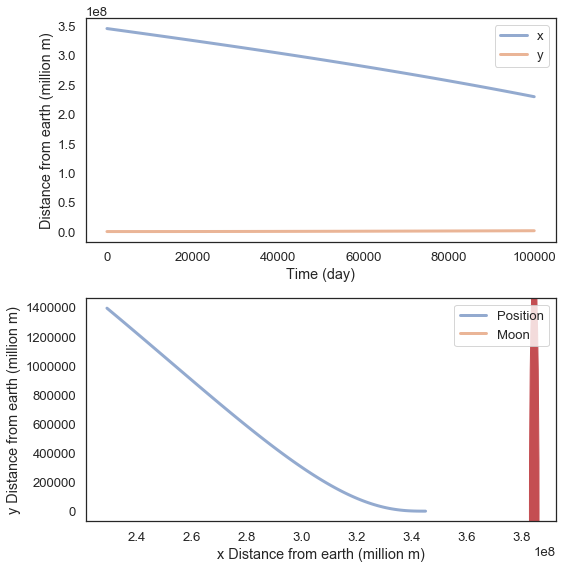

In [13]:
def plot_position(results):
    unpack(system)
    subplot(2,1,1)
    plot(results.x, label='x')
    plot(results.y, label = 'y')
    decorate(xlabel='Time (day)',
             ylabel='Distance from earth (million m)')
    subplot(2,1,2)
   

    plot(results.x,results.y, label = 'Position')
    plot(init.mx,init.my, label ='Moon')
    circle1 = plt.Circle((384472281, 0), 1736482, color='r')
    fig = plt.gcf()
    ax = fig.gca()
    ax.add_artist(circle1)
    decorate(xlabel='x Distance from earth (million m)',
             ylabel='y Distance from earth (million m)')
plot_position(results)

In [14]:
def plot_position2(results1, results2):
    
    unpack(system)
    subplot(2,1,1)
    plot(results1.x, label='x1')
    plot(results1.y, label = 'y1')
    plot(results2.x, label='x2')
    plot(results2.y, label = 'y2')
    decorate(xlabel='Time (day)',
             ylabel='Distance from earth (million m)')
    subplot(2,1,2)
    plot(results1.x,results1.y, label = 'Trajectory1')
    plot(results2.x,results2.y, label = 'Trajectory2')
    plot(results1.mx,results1.my)
    plot(results2.mx,results2.my)
    circle1 = plt.Circle((384472281, 0), 1736482, color='r')
    fig = plt.gcf()
    ax = fig.gca()
    ax.add_artist(circle1)
    circle3 = plt.Circle((get_last_value(results1.mx), get_last_value(results1.my)), 1736482, color='g')
    circle3 = plt.Circle((get_last_value(results2.mx), get_last_value(results2.my)), 1736482, color='g')
    fig = plt.gcf()
    ax = fig.gca()
    ax.add_artist(circle3)
    circle2 = plt.Circle((0, 0), 6371000, color='b')
    fig = plt.gcf()
    ax = fig.gca()
    ax.add_artist(circle2)
    decorate(xlabel='x Distance from earth (million m)',
             ylabel='y Distance from earth (million m)')


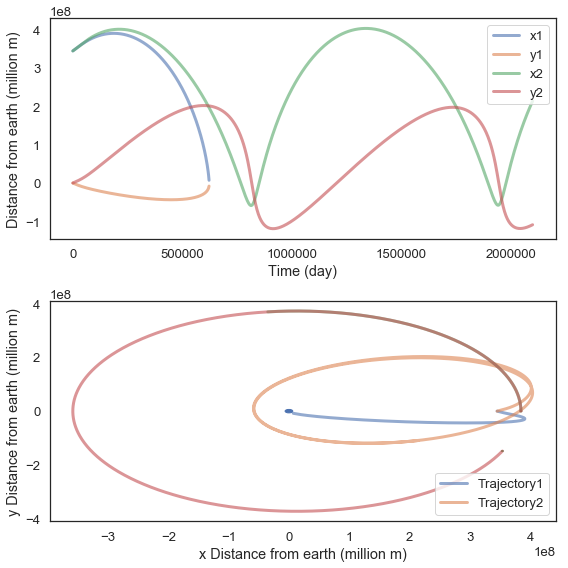

In [47]:
ts = linspace(system.t_0, system.t_end, 1000)

system = make_system(Mass_Earth, Mass_Moon, Mass_Satellite, G, r_0, 500,-30,2100000)
results1, details = run_ode_solver(system, slope_func, events = [event_func,event_func1],max_step=1000,method = "LSODA",t_eval=ts)

system = make_system(Mass_Earth, Mass_Moon, Mass_Satellite, G, r_0, 500,30,2100000)
results2, details = run_ode_solver(system, slope_func, events = [event_func,event_func1],max_step=1000, method = "LSODA",t_eval=ts)
plot_position2(results1,results2)

In [51]:
print(results2)

                         x             y           vx          vy  \
0.000000e+00  3.449709e+08  0.000000e+00   433.012702  250.000000   
2.102102e+03  3.458808e+08  5.257059e+05   432.817807  250.190661   
4.204204e+03  3.467906e+08  1.052186e+06   432.939394  250.666646   
6.306306e+03  3.477011e+08  1.579875e+06   433.319811  251.421220   
8.408408e+03  3.486127e+08  2.109548e+06   433.989323  252.542710   
1.051051e+04  3.495259e+08  2.641981e+06   434.916271  254.066245   
1.261261e+04  3.504413e+08  3.178028e+06   436.060982  256.024034   
1.471471e+04  3.513593e+08  3.718679e+06   437.371680  258.446105   
1.681682e+04  3.522802e+08  4.264937e+06   438.790496  261.352952   
1.891892e+04  3.532041e+08  4.817836e+06   440.253411  264.756119   
2.102102e+04  3.541311e+08  5.378389e+06   441.693861  268.656713   
2.312312e+04  3.550610e+08  5.947661e+06   443.038982  273.044422   
2.522523e+04  3.559936e+08  6.526649e+06   444.218335  277.896911   
2.732733e+04  3.569285e+08  7.1162

In [41]:
print(results2.mx[results2.index[10]])



384472280.99998194


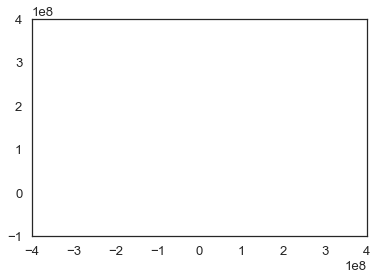

In [54]:
fig = plt.figure()
ax = plt.axes(xlim=(-4e8, 4e8), ylim=(-1e8, 4e8))
line, = ax.plot([], [], lw=2)

In [55]:
def init():
    line.set_data([], [])
    return line,

In [56]:
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

In [57]:
rc('animation', html='html5')


In [65]:
def animate1(i):
    x = results2.mx[results2.index[i]]
    y = results2.my[results2.index[i]]
    line.set_data(x, y)
    return line,

In [66]:
anim = animation.FuncAnimation(fig, animate1, init_func=init,
                               frames=50, interval=200, blit=True)


In [23]:
anim